In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
recovered_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
cols = recovered_cases.keys()
recoveries = recovered_cases.loc[:, cols[4]:cols[66]]
dates = recoveries.keys()
world_cases = []

for i in dates:
    recoveries_sum = recoveries[i].sum()
    world_cases.append(recoveries_sum)
  


days_since_1_22 = np.array([i for i in range(len(dates))])
#world_cases = np.array(world_cases).reshape(-1, 1)

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]


In [4]:
mycases=pd.DataFrame({"dates":days_since_1_22,"cases":world_cases})
mycases=mycases.set_index("dates")
len(mycases)
rolmean=pd.DataFrame(mycases['cases']).rolling(window=3).mean()
rolstd=pd.DataFrame(mycases['cases']).rolling(window=3).std()
print(rolmean,rolstd)

               cases
dates               
0                NaN
1                NaN
2          31.333333
3          35.000000
4          42.333333
...              ...
58      85227.333333
59      88010.333333
60      92319.333333
61      95968.666667
62     101409.333333

[63 rows x 1 columns]              cases
dates             
0              NaN
1              NaN
2         4.163332
3         4.582576
4         8.504901
...            ...
58     2054.284872
59     3396.965754
60     5271.082084
61     3730.038918
62     5705.516132

[63 rows x 1 columns]


In [5]:
rolmean['cases'].fillna(555, inplace=True)
print(rolmean['cases'].isnull().sum())


0


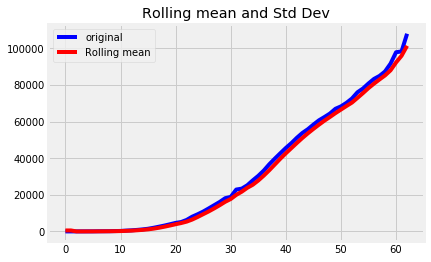

In [6]:
orig=plt.plot(mycases,color="blue",label="original")
mean=plt.plot(rolmean,color="red",label="Rolling mean")
plt.legend(loc="best")
plt.title("Rolling mean and Std Dev")
plt.show(block=False)

In [7]:
train_len = int(np.ceil(len(mycases) * 0.90))
print(len(mycases)-train_len)

6


In [8]:
train=rolmean[0:train_len] 
test=rolmean[train_len:]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 57
Test  data length : 6


In [9]:
x_train = train.drop('cases', axis=1)
x_test = test.drop('cases', axis=1)
y_train = train[['cases']]
y_test = test[['cases']]

In [10]:
model = SimpleExpSmoothing(train['cases'])

In [11]:
for i in np.arange(0.1,1,0.1):
    model_fit = model.fit(smoothing_level=i,optimized=False)
    y_hat_avg = test.copy()
    y_hat_avg['SES'] = model_fit.forecast(len(test['cases']))
    rmse = np.sqrt(mean_squared_error(test.cases, y_hat_avg.SES))
    rmse = round(rmse, 3)
    abs_error = np.abs(y_test['cases']-y_hat_avg.SES)
    actual = y_test['cases']
    mape = np.round(np.mean(abs_error/actual),4)
    print('smoothing_level : ',np.round(i,1),'RMSE : ' ,np.round(rmse,2) ,'MAPE : ',mape)

smoothing_level :  0.1 RMSE :  31652.14 MAPE :  0.3377
smoothing_level :  0.2 RMSE :  20807.97 MAPE :  0.2141
smoothing_level :  0.3 RMSE :  17149.47 MAPE :  0.1712
smoothing_level :  0.4 RMSE :  15337.74 MAPE :  0.1495
smoothing_level :  0.5 RMSE :  14239.14 MAPE :  0.1361
smoothing_level :  0.6 RMSE :  13499.16 MAPE :  0.1269
smoothing_level :  0.7 RMSE :  12970.24 MAPE :  0.1202
smoothing_level :  0.8 RMSE :  12577.61 MAPE :  0.1152
smoothing_level :  0.9 RMSE :  12278.14 MAPE :  0.1114


In [12]:
model_fit = model.fit(smoothing_level=0.9,optimized=True)
model_fit.params

{'smoothing_level': 0.9,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 549.7789341108161,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [13]:
y_hat_avg['SES'] = model_fit.forecast(len(test['cases']))

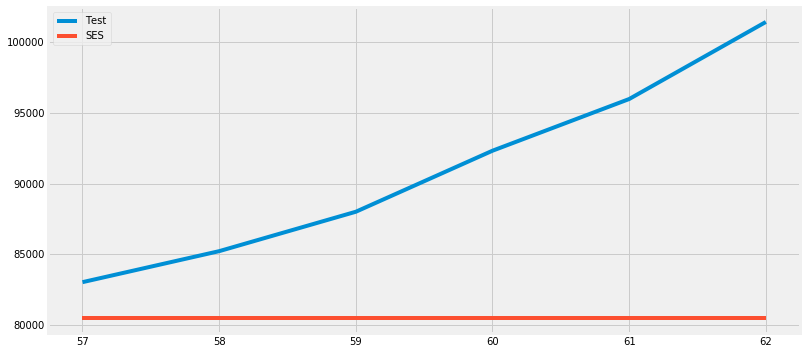

In [19]:
plt.figure(figsize=(12,6))
#plt.plot(train['cases'], label='Train')
plt.plot(test['cases'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')

In [15]:
from statsmodels.tsa.api import Holt
fit1 = Holt(np.asarray(train['cases']),exponential=True).fit(smoothing_level=1,smoothing_slope=1,damping_slope=1, optimized=True)
fit1.params

{'smoothing_level': 1.0,
 'smoothing_slope': 1.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 555.0,
 'initial_slope': 1.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [16]:
y_hat_avg['Holt'] = fit1.forecast(len(test))
print(y_hat_avg)

               cases         SES          Holt
dates                                         
57      83039.000000  80475.0905  83253.375135
58      85227.333333  80475.0905  85836.130423
59      88010.333333  80475.0905  88499.010088
60      92319.333333  80475.0905  91244.499816
61      95968.666667  80475.0905  94075.162405
62     101409.333333  80475.0905  96993.640157


In [28]:
ESPred=fit1.forecast(73)

In [29]:
#exponentialsmoothing
print('MAE:{}  || Actual Values: 1827 '.format(mean_absolute_error(y_hat_avg['Holt'], test['cases'])))
print('MSE:{}  || Actual Values: 5970634 '.format(mean_squared_error(y_hat_avg['Holt'], test['cases'])))

MAE:1449.3133224675184  || Actual Values: 1827 
MSE:4149061.2113305773  || Actual Values: 5970634 


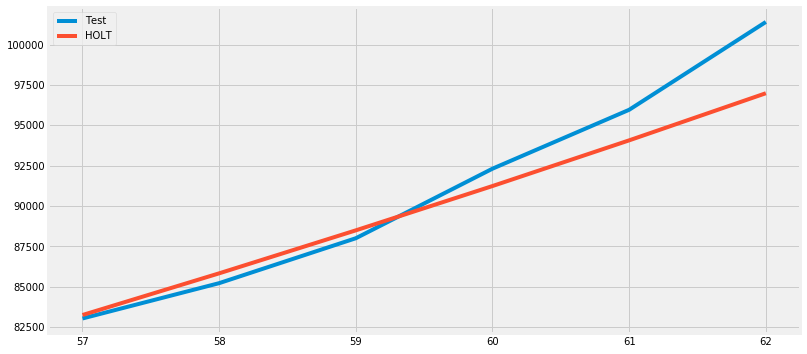

In [34]:
plt.figure(figsize=(12,6))
plt.plot(test['cases'], label='Test')
plt.plot(y_hat_avg['Holt'], label='HOLT')
plt.legend(loc='best')

In [30]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forecast, pred, linestyle='dashed', color=color)
    plt.title('Number of  recovered cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('Number of recoveries', size=30)
    plt.legend(['recoveries', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

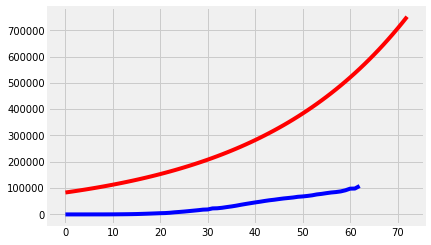

In [44]:
plt.plot(mycases['cases'],color="blue",label="original")
plt.plot(ESPred,color="red",label="Rolling mean")

In [49]:
 
plot_predictions(adjusted_dates, np.array(mycases['cases']).reshape(-1, 1), ESPred, 'Exponential Smoothing', 'red')

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

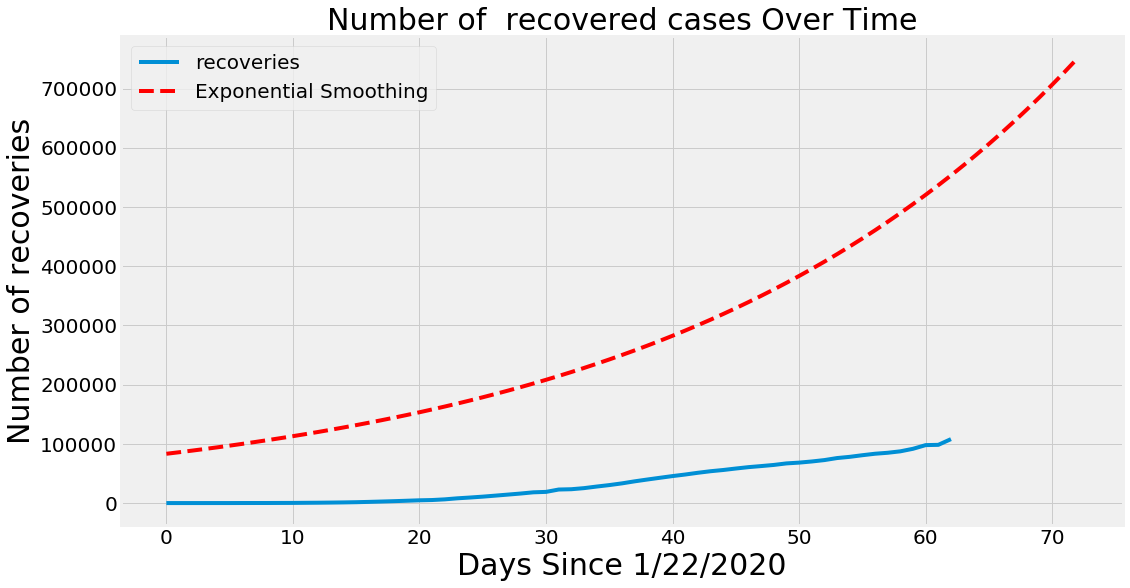

In [36]:
plot_predictions(adjusted_dates,world_cases, ESPred, 'Exponential Smoothing', 'red')